## SARIMA Forecasting



In [ ]:
!pip install pmdarima


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

data = {
    'Year': [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023],
    'Jan': [181, 2200, 6866, 14590, 27974, 24149, 30177, 62475, 133323],
    'Feb': [186, 2931, 7319, 12270, 23941, 22523, 30987, 67672, 138912],
    'Mar': [227, 5200, 10352, 13264, 27522, 22272, 40599, 91418, 179041],
    'Apr': [178, 4348, 8902, 12415, 22573, 1525, 23171, 84895, 139367],
    'May': [199, 4866, 11686, 13628, 20580, 2981, 6559, 85643, 184766],
    'Jun': [296, 5982, 12791, 13696, 19441, 12904, 19911, 88511, 129218],
    'Jul': [382, 5476, 13613, 16315, 19970, 14259, 41056, 93266, 139942],
    'Aug': [719, 5348, 12655, 16819, 20211, 16724, 42999, 107737, 153026],
    'Sep': [989, 5351, 11512, 19639, 23016, 20677, 47203, 114328, 155650],
    'Oct': [1143, 8069, 12436, 22012, 25874, 22074, 53808, 145033, 168116],
    'Nov': [1451, 5914, 15409, 21630, 27714, 25779, 57140, 147557, 180627],
    'Dec': [2441, 6032, 13037, 25279, 23417, 28043, 63847, 129690, 164253]
}

df = pd.DataFrame(data)

df_melted = pd.melt(df, id_vars=['Year'], var_name='Month', value_name='Sales')
df_melted['Date'] = pd.to_datetime(df_melted['Year'].astype(str) + '-' + df_melted['Month'], format='%Y-%b')
df_melted = df_melted.set_index('Date').sort_index()

df_melted = df_melted.drop(columns=['Year', 'Month'])

print(df_melted.head())


            Sales
Date             
2015-01-01    181
2015-02-01    186
2015-03-01    227
2015-04-01    178
2015-05-01    199


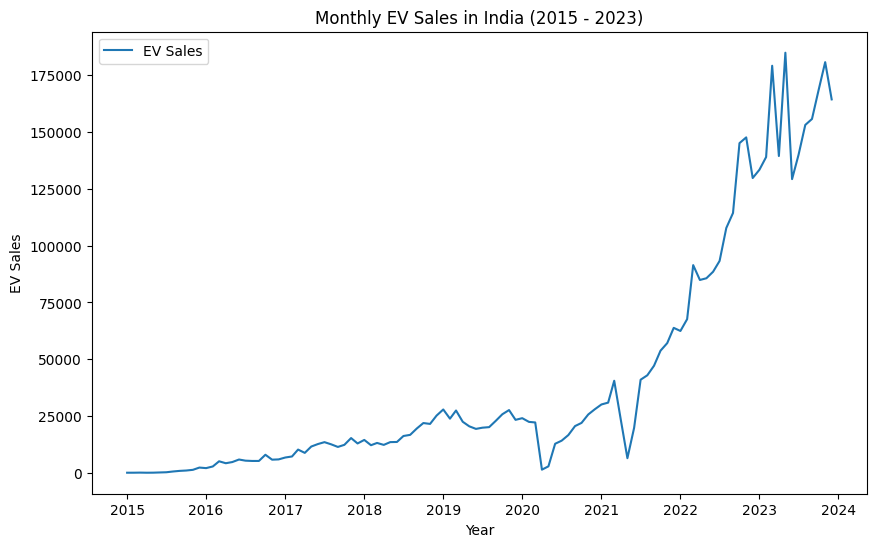

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(df_melted, label='EV Sales')
plt.title('Monthly EV Sales in India (2015 - 2023)')
plt.xlabel('Year')
plt.ylabel('EV Sales')
plt.legend()
plt.show()


In [ ]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(df_melted['Sales'])

print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')


ADF Statistic: 0.3302497409230973
p-value: 0.9786905470533788


In [ ]:
sarima_model = SARIMAX(df_melted['Sales'],
                       order=(1, 1, 1),              # Non-seasonal (p, d, q), d=1 for differencing
                       seasonal_order=(1, 1, 1, 12), # Seasonal (P, D, Q, S), D=1 for seasonal differencing
                       enforce_stationarity=False,
                       enforce_invertibility=False)

sarima_result = sarima_model.fit(disp=False)

print(sarima_result.summary())


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                  108
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -860.036
Date:                            Wed, 23 Oct 2024   AIC                           1730.073
Time:                                    20:37:48   BIC                           1742.045
Sample:                                01-01-2015   HQIC                          1734.876
                                     - 12-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4793      0.222     -2.155      0.031      -0.915      -0.043
ma.L1          0.0413      0.331   

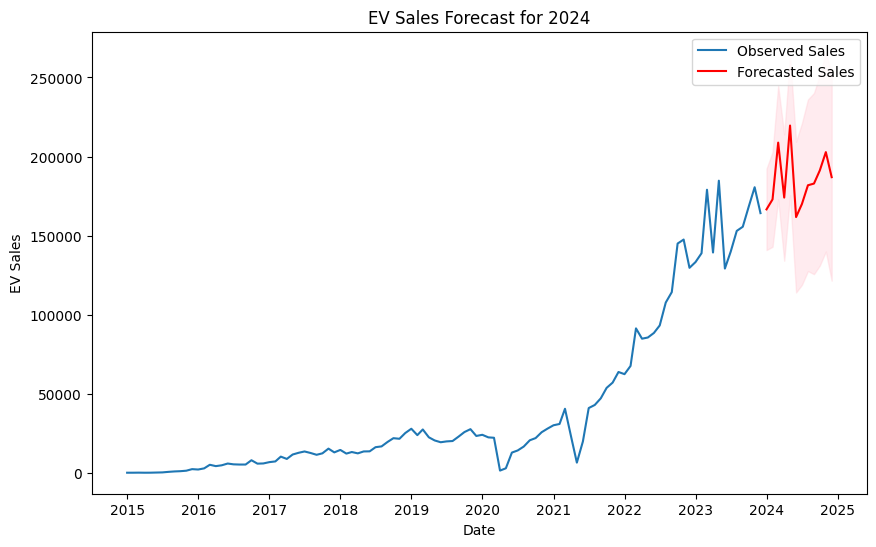

In [ ]:
forecast = sarima_result.get_forecast(steps=12)
forecast_index = pd.date_range(start='2024-01-01', periods=12, freq='MS')

forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

plt.figure(figsize=(10,6))
plt.plot(df_melted['Sales'], label='Observed Sales')
plt.plot(forecast_index, forecast_mean, label='Forecasted Sales', color='red')
plt.fill_between(forecast_index,
                 forecast_conf_int.iloc[:, 0],
                 forecast_conf_int.iloc[:, 1],
                 color='pink', alpha=0.3)
plt.title('EV Sales Forecast for 2024')
plt.xlabel('Date')
plt.ylabel('EV Sales')
plt.legend()
plt.show()


In [ ]:
train_pred = sarima_result.get_prediction(start=df_melted.index[0], end=df_melted.index[-1])
train_pred_mean = train_pred.predicted_mean

mse = mean_squared_error(df_melted['Sales'], train_pred_mean)
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {np.sqrt(mse)}')

Mean Squared Error: 82358702.03912629
Root Mean Squared Error: 9075.169532252623


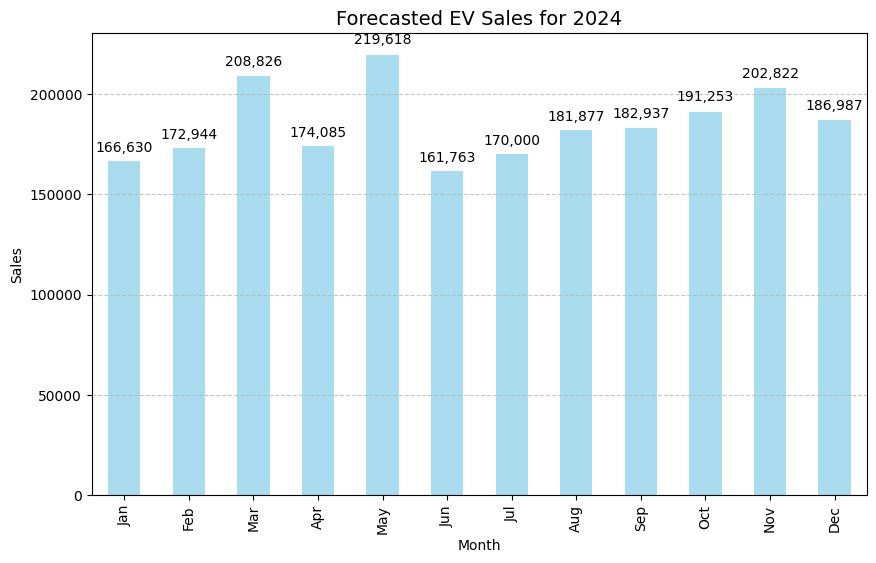

In [ ]:
import matplotlib.pyplot as plt

forecast = sarima_result.get_forecast(steps=12)
forecast_mean = forecast.predicted_mean

plt.figure(figsize=(10, 6))
forecast_mean.plot(kind='bar', color='skyblue', alpha=0.7)

for i, value in enumerate(forecast_mean):
    plt.text(i, value + 0.02 * value, f'{int(value):,}', ha='center', va='bottom')

plt.title('Forecasted EV Sales for 2024', fontsize=14)
plt.ylabel('Sales')
plt.xlabel('Month')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


In [ ]:
from pmdarima import auto_arima

auto_sarima_model = auto_arima(df_melted['Sales'],
                               start_p=0, start_q=0,
                               max_p=3, max_q=3,     # Tune non-seasonal (p, q)
                               d=1,                  # Keep d=1 as differencing is needed
                               start_P=0, start_Q=0,
                               max_P=3, max_Q=3,     # Tune seasonal (P, Q)
                               D=1, seasonal=True,
                               m=12,                 # Monthly seasonality (m=12)
                               trace=True,           # Set to True to see output
                               stepwise=False,        # More efficient search
                               suppress_warnings=True,
                               n_jobs=-1)            # Use all CPU cores

print(auto_sarima_model.summary())



Best model:  ARIMA(1,1,0)(2,1,0)[12]          
Total fit time: 78.963 seconds
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  108
Model:             SARIMAX(1, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -1003.935
Date:                            Wed, 23 Oct 2024   AIC                           2015.870
Time:                                    20:39:46   BIC                           2026.085
Sample:                                01-01-2015   HQIC                          2019.998
                                     - 12-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4668      0.051   

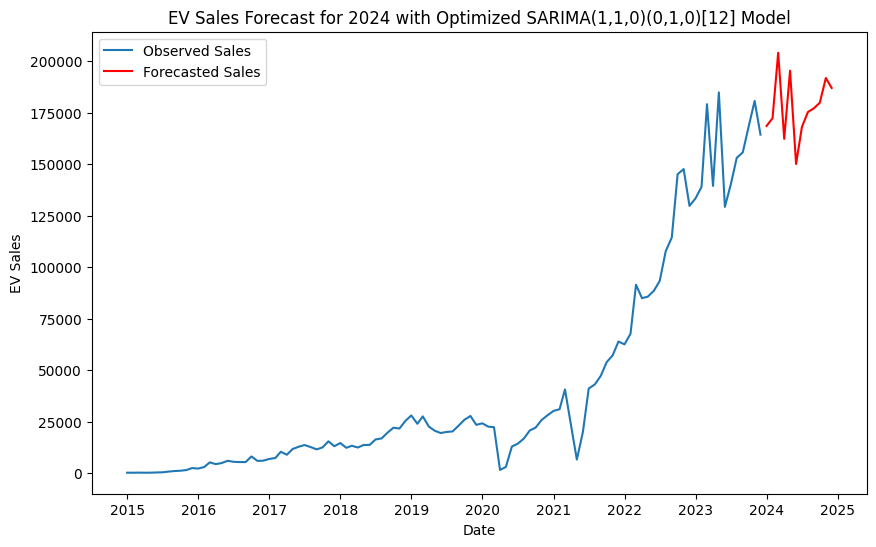

In [ ]:
best_sarima_model = auto_sarima_model.fit(df_melted['Sales'])

forecast_rev = best_sarima_model.predict(n_periods=12)
forecast_index_rev = pd.date_range(start='2024-01-01', periods=12, freq='MS')

plt.figure(figsize=(10, 6))
plt.plot(df_melted['Sales'], label='Observed Sales')
plt.plot(forecast_index_rev, forecast_rev, label='Forecasted Sales', color='red')
plt.title('EV Sales Forecast for 2024 with Optimized SARIMA(1,1,0)(0,1,0)[12] Model')
plt.xlabel('Date')
plt.ylabel('EV Sales')
plt.legend()
plt.show()


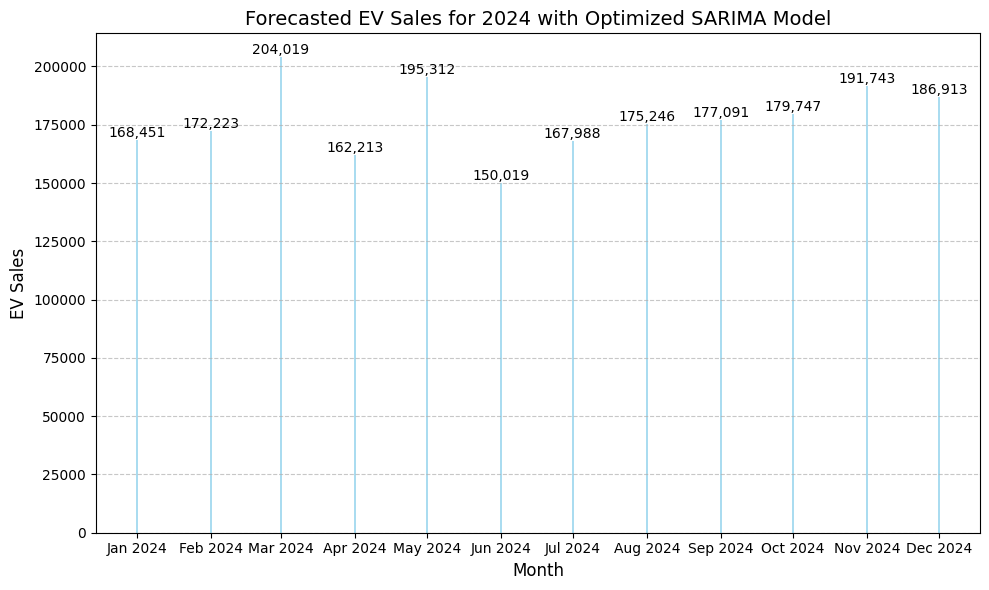

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(forecast_index_rev, forecast_rev, color='skyblue', alpha=0.7)

for i, value in enumerate(forecast_rev):
    plt.text(forecast_index_rev[i], value, f'{int(value):,}', ha='center', va='bottom', fontsize=10)

plt.title('Forecasted EV Sales for 2024 with Optimized SARIMA Model', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('EV Sales', fontsize=12)
plt.xticks(forecast_index_rev, [date.strftime('%b %Y') for date in forecast_index_rev])
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


EV Optimized Model - Mean Squared Error: 74889388.41245979
EV Optimized Model - Root Mean Squared Error: 8653.865518510198


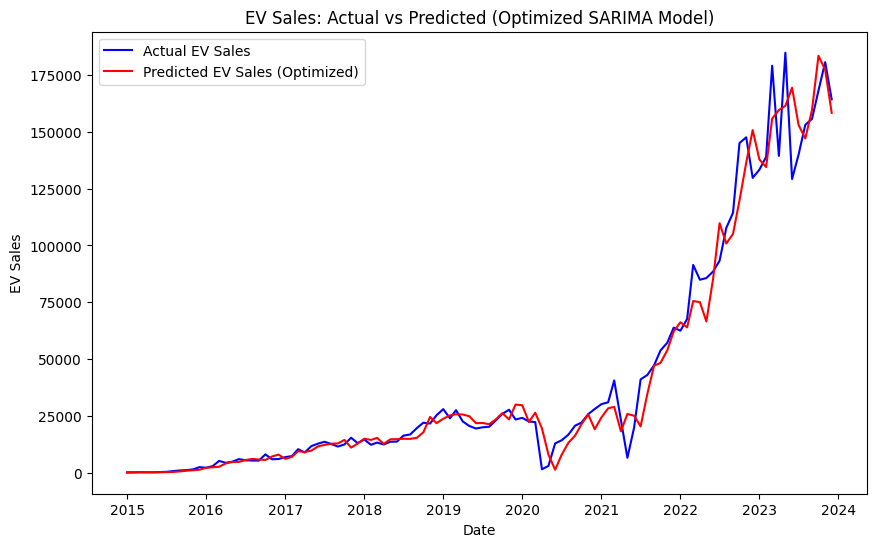

In [ ]:
ev_train_pred_opt = best_sarima_model.predict_in_sample()

ev_mse_opt = mean_squared_error(df_melted['Sales'], ev_train_pred_opt)
ev_rmse_opt = np.sqrt(ev_mse_opt)

print(f'EV Optimized Model - Mean Squared Error: {ev_mse_opt}')
print(f'EV Optimized Model - Root Mean Squared Error: {ev_rmse_opt}')

# Plot the actual vs predicted sales for EV
plt.figure(figsize=(10, 6))
plt.plot(df_melted.index, df_melted['Sales'], label='Actual EV Sales', color='blue')
plt.plot(df_melted.index, ev_train_pred_opt, label='Predicted EV Sales (Optimized)', color='red')
plt.title('EV Sales: Actual vs Predicted (Optimized SARIMA Model)')
plt.xlabel('Date')
plt.ylabel('EV Sales')
plt.legend()
plt.show()


In [ ]:
initial_forecast = list(forecast_mean)
initial_forecast = initial_forecast[:9]
initial_forecast

[166630.0629530786,
 172944.37096909818,
 208826.90313093766,
 174085.70991125557,
 219618.7651048934,
 161763.56400443072,
 170000.93141225757,
 181877.7502205658,
 182937.20093883356]

In [ ]:
optimized_forecast = list(forecast_rev)
optimized_forecast = optimized_forecast[:9]
optimized_forecast

[168451.55896099098,
 172223.94541337257,
 204019.84313179817,
 162213.52873413864,
 195312.79209804948,
 150019.39087808726,
 167988.32902092906,
 175246.70115919973,
 177091.9378011652]

In [ ]:
actual_sales = [176820,	172653,	242566,	146391,	167740,	165320,	209867,	186342,	186140]

In [ ]:
abs_error_ini = abs(np.array(actual_sales) - np.array(initial_forecast))
abs_error_opt = abs(np.array(actual_sales) - np.array(optimized_forecast))

In [ ]:
mad_ini = abs_error_ini.mean()
mad_ini

19431.49259168258

In [ ]:
mad_opt = abs_error_opt.mean()
mad_opt

18673.51271851613

In [ ]:
mse_ini = np.square(abs_error_ini).mean()
mse_ini

703643189.6701868

In [ ]:
mse_opt = np.square(abs_error_opt).mean()
mse_opt

528837465.62112087

In [ ]:
rmse_ini = np.sqrt(mse_ini)
rmse_ini

26526.27357301034

In [ ]:
rmse_opt = np.sqrt(mse_opt)
rmse_opt

22996.46637249125

In [ ]:
mape_ini = (abs_error_ini / actual_sales).mean() * 100
mape_ini

10.550086073474807

In [ ]:
mape_opt = (abs_error_opt / actual_sales).mean() * 100
mape_opt

9.793737219853728

In [ ]:
# Non-EV sales data
non_ev_data = {
    'Year': [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023],
    'Jan': [1615762, 1722207, 1626801, 2086081, 2092373, 1969876, 1826324, 1557204, 1717816],
    'Feb': [1533576, 1735125, 1646977, 1885994, 1867260, 1930177, 1666020, 1472012, 1657409],
    'Mar': [1622361, 1745988, 2240320, 2182055, 2053042, 2562756, 1825268, 1704311, 1884990],
    'Apr': [1560763, 1723489, 1914195, 2113031, 1946742, 482974, 1284487, 1716554, 1602671],
    'May': [1644704, 1835486, 1992815, 2293762, 2052040, 238569, 589891, 1750300, 1853054],
    'Jun': [1700653, 1803463, 1927347, 2080532, 1899454, 1120206, 1382264, 1614742, 1753850],
    'Jul': [1648798, 1672994, 1790157, 2100375, 2012286, 1308887, 1724857, 1517414, 1647976],
    'Aug': [1468918, 1656469, 1715956, 1937499, 1786490, 1377830, 1513034, 1567769, 1686662],
    'Sep': [1534395, 1621850, 1772188, 1895645, 1625170, 1535506, 1407748, 1450618, 1744888],
    'Oct': [1540678, 1977266, 2233602, 1990751, 2092941, 1633304, 1490593, 2151383, 1977342],
    'Nov': [1947340, 2117535, 2431113, 2376313, 2495112, 2090045, 1969605, 2263527, 2705988],
    'Dec': [1737717, 1527524, 1766722, 2161574, 1861202, 2084252, 1692787, 1515473, 1844096]
}

non_ev_df = pd.DataFrame(non_ev_data)

non_ev_df_melted = pd.melt(non_ev_df, id_vars=['Year'], var_name='Month', value_name='Sales')
non_ev_df_melted['Date'] = pd.to_datetime(non_ev_df_melted['Year'].astype(str) + '-' + non_ev_df_melted['Month'], format='%Y-%b')
non_ev_df_melted = non_ev_df_melted.set_index('Date').sort_index()

non_ev_df_melted = non_ev_df_melted.drop(columns=['Year', 'Month'])

print(non_ev_df_melted.head())


              Sales
Date               
2015-01-01  1615762
2015-02-01  1533576
2015-03-01  1622361
2015-04-01  1560763
2015-05-01  1644704


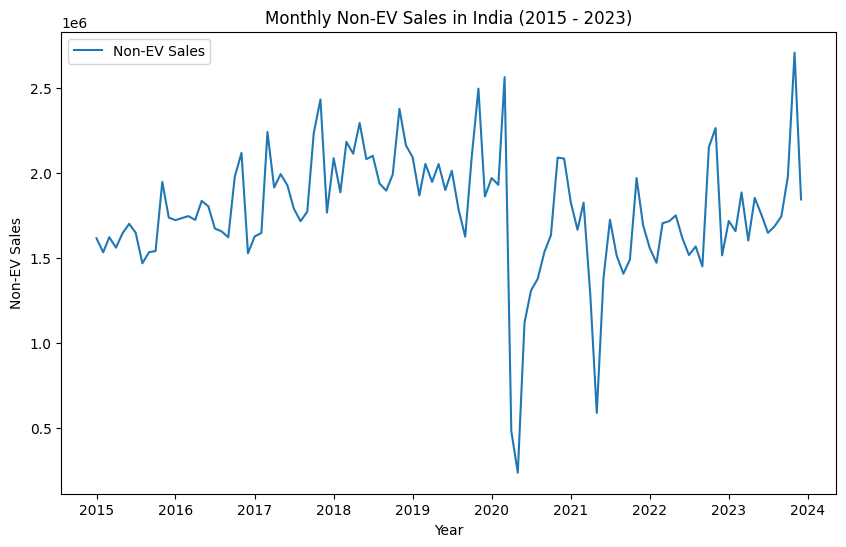

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(non_ev_df_melted, label='Non-EV Sales')
plt.title('Monthly Non-EV Sales in India (2015 - 2023)')
plt.xlabel('Year')
plt.ylabel('Non-EV Sales')
plt.legend()
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller

non_ev_adf_test = adfuller(non_ev_df_melted['Sales'])

print(f'ADF Statistic: {non_ev_adf_test[0]}')
print(f'p-value: {non_ev_adf_test[1]}')

ADF Statistic: -1.4067680683163202
p-value: 0.5790271548002831


In [ ]:
non_ev_sarima_model = SARIMAX(non_ev_df_melted['Sales'],
                              order=(1, 1, 1),
                              seasonal_order=(1, 1, 1, 12),
                              enforce_stationarity=False,
                              enforce_invertibility=False)

non_ev_sarima_result = non_ev_sarima_model.fit(disp=False)

print(non_ev_sarima_result.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                  108
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1146.431
Date:                            Wed, 23 Oct 2024   AIC                           2302.862
Time:                                    20:41:42   BIC                           2314.834
Sample:                                01-01-2015   HQIC                          2307.665
                                     - 12-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3530      0.226      1.562      0.118      -0.090       0.796
ma.L1         -0.7617      0.222   

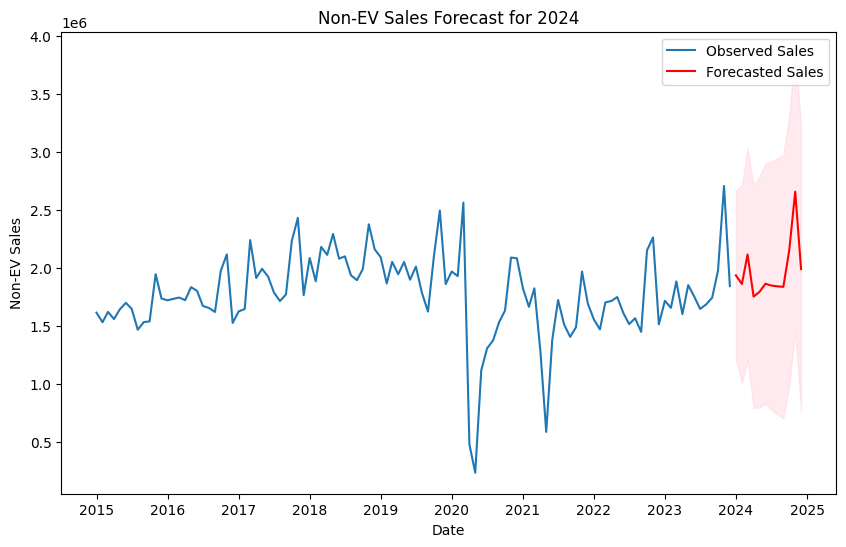

In [ ]:
non_ev_forecast = non_ev_sarima_result.get_forecast(steps=12)
non_ev_forecast_index = pd.date_range(start='2024-01-01', periods=12, freq='MS')

non_ev_forecast_mean = non_ev_forecast.predicted_mean
non_ev_forecast_conf_int = non_ev_forecast.conf_int()

plt.figure(figsize=(10,6))
plt.plot(non_ev_df_melted['Sales'], label='Observed Sales')
plt.plot(non_ev_forecast_index, non_ev_forecast_mean, label='Forecasted Sales', color='red')
plt.fill_between(non_ev_forecast_index,
                 non_ev_forecast_conf_int.iloc[:, 0],
                 non_ev_forecast_conf_int.iloc[:, 1],
                 color='pink', alpha=0.3)
plt.title('Non-EV Sales Forecast for 2024')
plt.xlabel('Date')
plt.ylabel('Non-EV Sales')
plt.legend()
plt.show()

In [ ]:
non_ev_train_pred = non_ev_sarima_result.get_prediction(start=non_ev_df_melted.index[0], end=non_ev_df_melted.index[-1])
non_ev_train_pred_mean = non_ev_train_pred.predicted_mean

non_ev_mse = mean_squared_error(non_ev_df_melted['Sales'], non_ev_train_pred_mean)
print(f'Mean Squared Error: {non_ev_mse}')
print(f'Root Mean Squared Error: {np.sqrt(non_ev_mse)}')

Mean Squared Error: 137770928823.9897
Root Mean Squared Error: 371175.06492757524


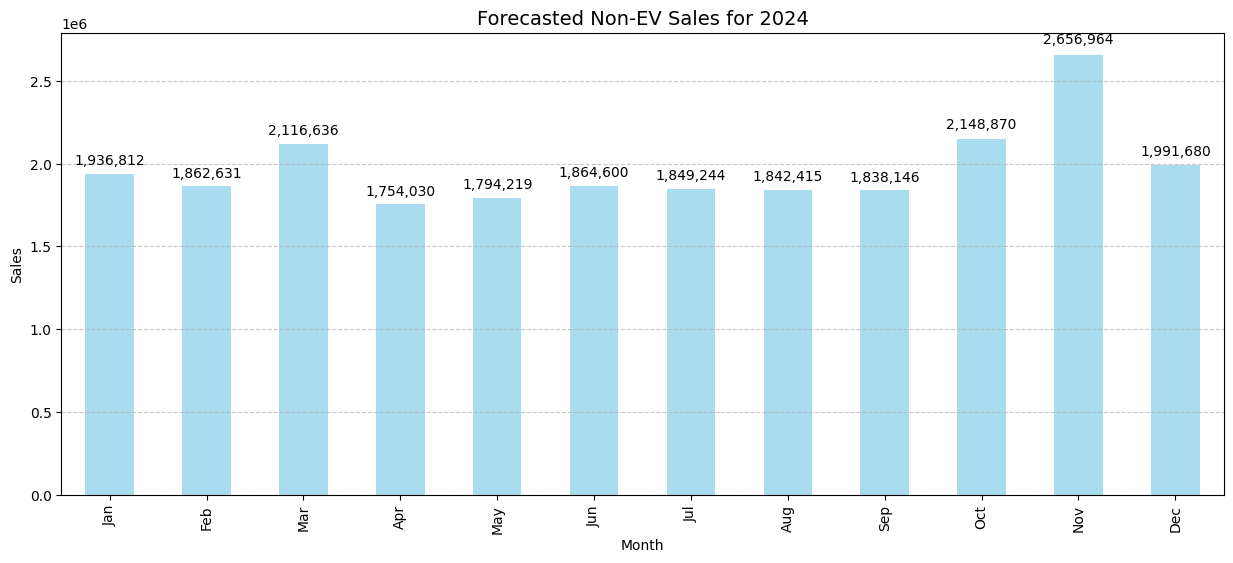

In [ ]:
plt.figure(figsize=(15, 6))
non_ev_forecast_mean.plot(kind='bar', color='skyblue', alpha=0.7)

for i, value in enumerate(non_ev_forecast_mean):
    plt.text(i, value + 0.02 * value, f'{int(value):,}', ha='center', va='bottom')

plt.title('Forecasted Non-EV Sales for 2024', fontsize=14)
plt.ylabel('Sales')
plt.xlabel('Month')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


In [ ]:
from pmdarima import auto_arima

non_ev_auto_sarima_model = auto_arima(non_ev_df_melted['Sales'],
                                      start_p=0, start_q=0,
                                      max_p=3, max_q=3,
                                      d=1,
                                      start_P=0, start_Q=0,
                                      max_P=3, max_Q=3,
                                      D=1, seasonal=True,
                                      m=12,
                                      trace=True,
                                      stepwise=False,
                                      suppress_warnings=True,
                                      n_jobs=-1)

print(non_ev_auto_sarima_model.summary())


Best model:  ARIMA(0,1,2)(0,1,1)[12]          
Total fit time: 58.753 seconds
                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  108
Model:             SARIMAX(0, 1, 2)x(0, 1, [1], 12)   Log Likelihood               -1339.536
Date:                              Wed, 23 Oct 2024   AIC                           2687.071
Time:                                      20:43:05   BIC                           2697.287
Sample:                                  01-01-2015   HQIC                          2691.199
                                       - 12-01-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.16

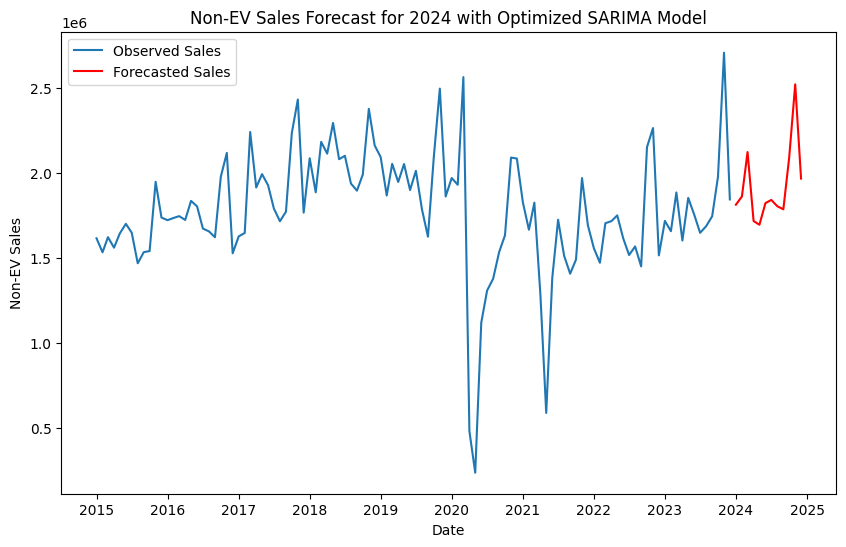

In [ ]:
non_ev_best_sarima_model = non_ev_auto_sarima_model.fit(non_ev_df_melted['Sales'])

non_ev_forecast_rev = non_ev_best_sarima_model.predict(n_periods=12)
non_ev_forecast_index_rev = pd.date_range(start='2024-01-01', periods=12, freq='MS')

plt.figure(figsize=(10, 6))
plt.plot(non_ev_df_melted['Sales'], label='Observed Sales')
plt.plot(non_ev_forecast_index_rev, non_ev_forecast_rev, label='Forecasted Sales', color='red')
plt.title('Non-EV Sales Forecast for 2024 with Optimized SARIMA Model')
plt.xlabel('Date')
plt.ylabel('Non-EV Sales')
plt.legend()
plt.show()

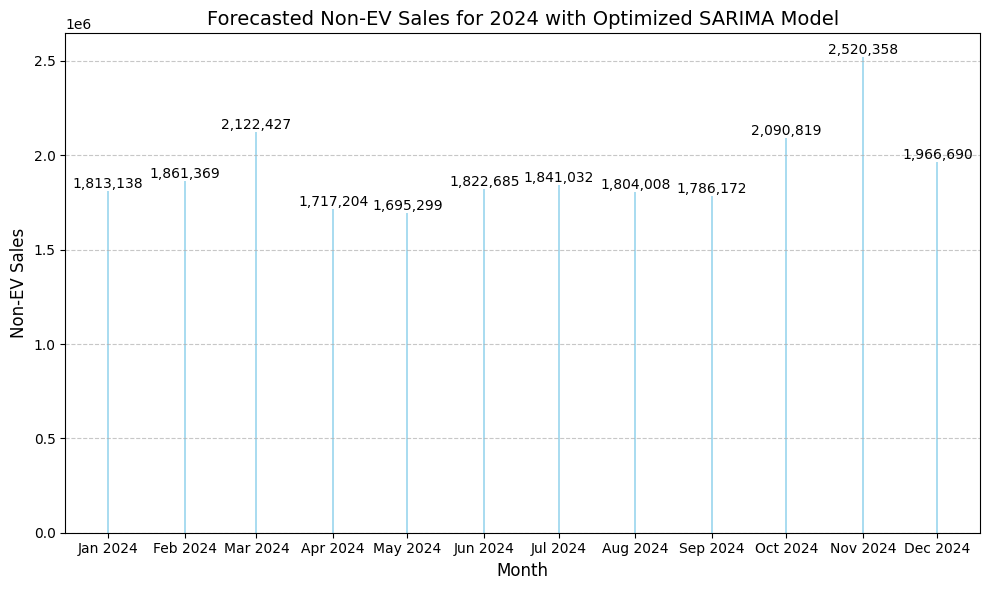

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(non_ev_forecast_index_rev, non_ev_forecast_rev, color='skyblue', alpha=0.7)

for i, value in enumerate(non_ev_forecast_rev):
    plt.text(non_ev_forecast_index_rev[i], value, f'{int(value):,}', ha='center', va='bottom', fontsize=10)

plt.title('Forecasted Non-EV Sales for 2024 with Optimized SARIMA Model', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Non-EV Sales', fontsize=12)
plt.xticks(non_ev_forecast_index_rev, [date.strftime('%b %Y') for date in non_ev_forecast_index_rev])
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

Non-EV Optimized Model - Mean Squared Error: 122294481132.61604
Non-EV Optimized Model - Root Mean Squared Error: 349706.2783717445


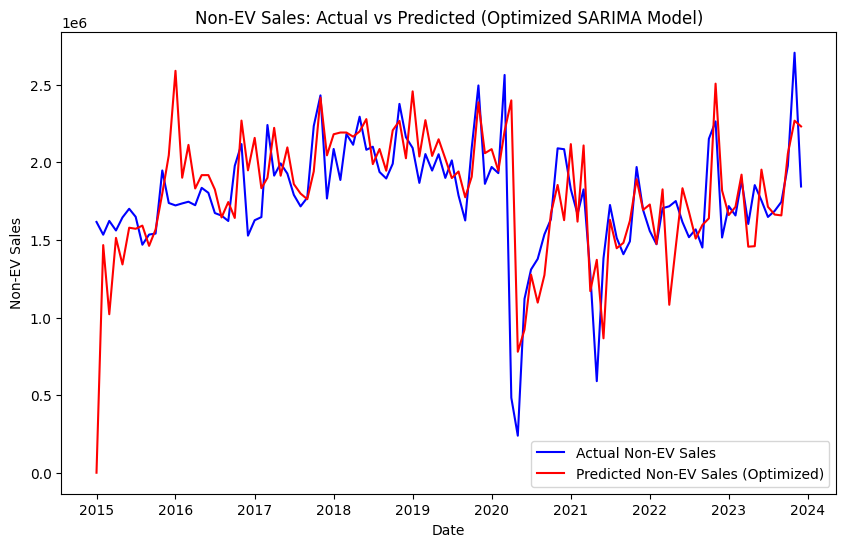

In [ ]:
non_ev_train_pred_opt = non_ev_best_sarima_model.predict_in_sample()

# Calculate Mean Squared Error for the Non-EV optimized model
non_ev_mse_opt = mean_squared_error(non_ev_df_melted['Sales'], non_ev_train_pred_opt)
non_ev_rmse_opt = np.sqrt(non_ev_mse_opt)

print(f'Non-EV Optimized Model - Mean Squared Error: {non_ev_mse_opt}')
print(f'Non-EV Optimized Model - Root Mean Squared Error: {non_ev_rmse_opt}')

# Plot the actual vs predicted sales for Non-EV
plt.figure(figsize=(10, 6))
plt.plot(non_ev_df_melted.index, non_ev_df_melted['Sales'], label='Actual Non-EV Sales', color='blue')
plt.plot(non_ev_df_melted.index, non_ev_train_pred_opt, label='Predicted Non-EV Sales (Optimized)', color='red')
plt.title('Non-EV Sales: Actual vs Predicted (Optimized SARIMA Model)')
plt.xlabel('Date')
plt.ylabel('Non-EV Sales')
plt.legend()
plt.show()


In [ ]:
non_ev_initial_forecast = list(non_ev_forecast_mean)
non_ev_initial_forecast = non_ev_initial_forecast[:9]
non_ev_initial_forecast

[1936812.7819872312,
 1862631.6534247,
 2116636.9247313277,
 1754030.8006054112,
 1794219.6261553054,
 1864600.3348684488,
 1849244.4615249606,
 1842415.526946013,
 1838146.974826233]

In [ ]:
non_ev_optimized_forecast = list(non_ev_forecast_rev)
non_ev_optimized_forecast = non_ev_optimized_forecast[:9]
non_ev_optimized_forecast

[1813138.4240064488,
 1861369.8442923524,
 2122427.70207081,
 1717204.0928721789,
 1695299.2994603517,
 1822685.9355915512,
 1841032.0226403216,
 1804008.5811128912,
 1786172.6757804397]

In [ ]:
non_ev_actual_sales = [1973562,	1874995,	1900191,	2077211,	1937138,	1745811,	1842098,	1721680,	1543336]

In [ ]:
non_ev_abs_error_ini = abs(np.array(non_ev_actual_sales) - np.array(non_ev_initial_forecast))
non_ev_abs_error_opt = abs(np.array(non_ev_actual_sales) - np.array(non_ev_optimized_forecast))

In [ ]:
non_ev_mad_ini = non_ev_abs_error_ini.mean()
non_ev_mad_ini

141459.92896937058

In [ ]:
non_ev_mad_opt = non_ev_abs_error_opt.mean()
non_ev_mad_opt

155693.02347600428

In [ ]:
non_ev_mse_ini = np.square(non_ev_abs_error_ini).mean()
non_ev_mse_ini

32097317210.53001

In [ ]:
non_ev_mse_opt = np.square(non_ev_abs_error_opt).mean()
non_ev_mse_opt

37228887667.82938

In [ ]:
non_ev_rmse_ini = np.sqrt(non_ev_mse_ini)
non_ev_rmse_ini

179157.2415799317

In [ ]:
non_ev_rmse_opt = np.sqrt(non_ev_mse_opt)
non_ev_rmse_opt

192947.88847725018

In [ ]:
non_ev_mape_ini = (non_ev_abs_error_ini / non_ev_actual_sales).mean() * 100
non_ev_mape_ini

7.795048118478825

In [ ]:
non_ev_mape_opt = (non_ev_abs_error_opt / non_ev_actual_sales).mean() * 100
non_ev_mape_opt

8.371562340962916